In [51]:
# Prepare input data
import ast
import pandas as pd
import numpy as np
from math import isnan
from collections import Counter
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import box
from sklearn.model_selection import train_test_split
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine


# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

# Import only first 1000 lines for testing
df = pd.read_csv('./data/sensor_readings_timeseries_part2.csv', nrows=500, parse_dates=["Timestamp"])
df = df.drop(
    ["Metadata.Location.type", "Metadata.SensorCommunitySensorType", "Metadata.SensorType", "_id"], axis=1)

# Convert string coordinates to list
df["Metadata.Location.coordinates"] = df["Metadata.Location.coordinates"].apply(
    lambda x: ast.literal_eval(x))

# no preprocessing needed
sensor_community_df = df.loc[df["Metadata.Provider"] == "sensor.community"].drop(
    ["Metadata.Provider", "Metadata.NetatmoSensorId"], axis=1)

# need to combine multiple entries for the same sensor id and time
netatmo_df = df.loc[df["Metadata.Provider"] == "netatmo"].drop(
    ["Metadata.Provider"], axis=1)

# get unique groups
grouped = netatmo_df.groupby(
    ["Metadata.NetatmoSensorId", "Timestamp"]).aggregate(list)

combined_rows = []
for label, group in grouped.iterrows():
    humidity = next((x for x in group.values[0] if not isnan(x)), np.NaN)
    pressure = next((x for x in group.values[2] if not isnan(x)), np.NaN)
    temperature = next((x for x in group.values[3] if not isnan(x)), np.NaN)

    # Humidity, Metadata.Location.coordinates, Pressure, Temperature, Timestamp
    entry = [humidity, group.values[1][0], pressure, temperature, label[1]]
    combined_rows.append(entry)

netatmo_df = pd.DataFrame(combined_rows, columns=[
                          "Humidity", "Metadata.Location.coordinates", "Pressure", "Temperature", "Timestamp"])

# Combine prepared data
prep = pd.concat([sensor_community_df, netatmo_df], ignore_index=True, axis=0)
prep = prep[prep["Temperature"].notna()]

coordinates = prep["Metadata.Location.coordinates"]
proj_wgs = 4326

geo_df = GeoDataFrame(prep[["Humidity", "Pressure", "Temperature", "Timestamp"]],
                          geometry=prep["Metadata.Location.coordinates"].apply(lambda row: Point(row[0], row[1])), crs=proj_wgs)


Text(0.5, 1.0, 'Temperature in Hamburg')

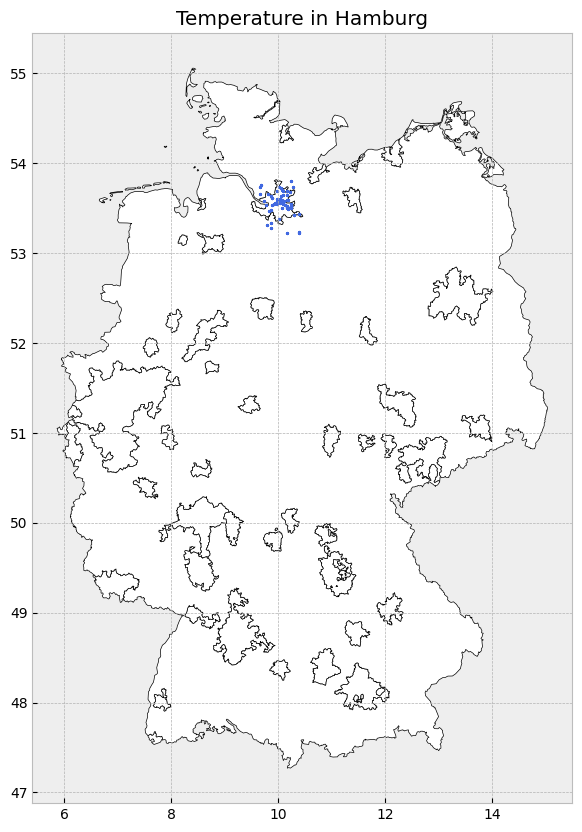

In [52]:
# Plot data
from geopandas.tools import sjoin

# Hamburg boundaries
# hamburg = gpd.read_file('./data/hamburg.shx')
# hamburg = hamburg.to_crs(proj_wgs)

# hamburg = hamburg.clip_by_rect(geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3])

# basisview = gpd.read_file(
#     './data/basisviews_bdlm_HH_EPSG_4326_2023-04-25.gpkg')
# basisview = basisview.to_crs(proj_wgs)

# basisview = basisview.clip_by_rect(geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3])

ge5000 = gpd.read_file(
    './data/ge5000.utm32s.shape/ge5000/vrm/VRM5000.shp')
ge5000 = ge5000.to_crs(proj_wgs)

# ge5000 = ge5000.clip_by_rect(geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3])


# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.style.use('bmh')

ge5000.plot(ax=ax, color='white', edgecolor='black')
# hamburg.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, marker='o', color='royalblue', markersize=3)


ax.set_title('Temperature in Hamburg')


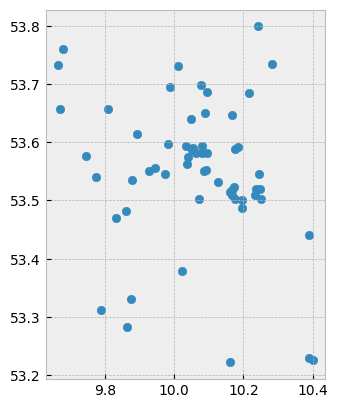

In [53]:
# Create test dataset
from pytz import UTC

start_time = pd.to_datetime('2023-02-02T20:00:00.000000000').tz_localize(UTC)
end_time = pd.to_datetime('2023-02-02T20:05:00.000000000').tz_localize(UTC)
filtered_gdf = geo_df.loc[(geo_df['Timestamp'] >= start_time)
                          & (geo_df['Timestamp'] <= end_time)]

filtered_gdf.plot()

def to_numpy_list(geo_series):
    return [[point.x, point.y]
            for point in geo_series.to_numpy()]

def geo_df_to_train_test_sets(gdf: gpd.GeoDataFrame) :
    coords_train, coords_test, value_train, value_test = train_test_split(
        gdf.geometry, gdf.Temperature, test_size=0.2, random_state=0)
    
    coords_train = to_numpy_list(coords_train)
    coords_test = to_numpy_list(coords_test)

    return coords_train, coords_test, value_train, value_test

coords_geo_train, coords_geo_test, value_geo_train, value_geo_test = geo_df_to_train_test_sets(filtered_gdf)
# Add cross validation
# print(coords_geo_train)
# print(coords_geo_train)
# print(value_geo_train)
# print(value_geo_train)


In [54]:
from sklearn import neighbors

n_neighbors = 5

knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')


# Fit regressor to data
knn_regressor.fit(coords_geo_train, value_geo_train)

# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_geo_test, value_geo_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_rain_test_predict_knn = knn_regressor.predict(coords_geo_test)

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"Coordinate_Pair": coords_geo_test,
                    "VALUE_Actual": value_geo_test, "VALUE_Predict": coords_rain_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(10))


KNN out-of-sample r-squared: -1.92

Attribute Table: Testing Set Interpolated Values - KNN Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
186,"[10.08, 53.582]",7.98,7.084931
261,"[10.184, 53.592]",4.55,5.466880
315,"[9.9886339555, 53.6937804]",5.40,4.748864
197,"[10.022, 53.378]",5.35,6.682210
74,"[10.04, 53.574]",5.24,7.011791
16,"[9.894, 53.614]",4.70,6.043133
244,"[10.096, 53.582]",5.11,7.084937
344,"[9.746, 53.576]",4.22,6.162308
297,"[9.774, 53.54]",4.96,5.782469
162,"[9.862, 53.482]",3.92,6.862244


In [55]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(
        min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode="w",
            driver="GTiff",
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs=proj,
            transform=transform,
    ) as new_dataset:
        new_dataset.write(Z, 1)

In [56]:
# Reference Krigin interpolation
# see: https://pygis.io/docs/e_interpolation.html#kriging
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score

# Define functions
def interpolate_ordinary_kriging(base_gdf: GeoDataFrame, variogram_model: str):
    """
    Interpolate data using ordinary kriging.

    :param base_gdf: GeoDataFrame containing the data to be interpolated
    :param variogram_model: The variogram model to be used for interpolation. Possible values: linear, power, gaussian, spherical, exponential, hole-effect

    """
    x_coords = base_gdf.geometry.x
    y_coords = base_gdf.geometry.y

    coords_train, coords_test, value_train, value_test = geo_df_to_train_test_sets(
        base_gdf)
    
    # Get outer bounds for data points
    minx, miny, maxx, maxy = geo_df.total_bounds

    # Add buffer to outer bounds
    minx -= .2
    miny -= .1
    maxx += .2
    maxy += .1

    # Create a 100 by 100 grid from the outer bounds
    grid_lon = np.linspace(minx, maxx, 100)
    grid_lat = np.linspace(miny, maxy, 100)

    # Generate ordinary krigin object
    OK = OrdinaryKriging(
        [item[0] for item in coords_train],
        [item[1] for item in coords_train],
        value_train,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False,
        coordinates_type="euclidean",
    )

    # Evaluate the method on grid
    Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", grid_lon, grid_lat)


    # Export raster
    export_kde_raster(Z=Z_pk_krig, XX=grid_lon, YY=grid_lat, min_x=minx, max_x=maxx, min_y=miny,
                  max_y=maxy, proj=proj_wgs, filename=f'./data/hamburg_temperature_krigin_{variogram_model}.tif')

    # Open raster
    raster_pk = rasterio.open('./data/hamburg_temperature_krigin.tif')

    # Create polygon with extend of raster
    poly_shapely = box(*raster_pk.bounds)

    # Create a dictionary with needed attributes and required geometry column
    attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

    # Convert shapely object to a GeoDataFrame
    raster_pk_extent = GeoDataFrame(
        attributes_df, geometry='geometry', crs=proj_wgs)
    
    # Create copy of test dataset
    temp_test_gdf_pk_krig = base_gdf.copy()

    # Subset the GeoDataFrame by checking which test points are within the raster extent polygon
    # If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
    temp_test_gdf_pk_krig = temp_test_gdf_pk_krig[temp_test_gdf_pk_krig.within(
        raster_pk_extent.geometry.values[0])]

    # Create list of XY coordinate pairs for the test points that fall within raster extent polygon
    coords_rain_test_pk_krig = [list(xy) for xy in zip(
        temp_test_gdf_pk_krig["geometry"].x, temp_test_gdf_pk_krig["geometry"].y)]

    # Extract raster value at each test point and add the values to the GeoDataFrame
    temp_test_gdf_pk_krig["VALUE_Predict"] = [x[0]
                                            for x in raster_pk.sample(coords_rain_test_pk_krig)]

    # Generate out-of-sample R^2
    out_r_squared_tp = r2_score(
        temp_test_gdf_pk_krig.Temperature, temp_test_gdf_pk_krig.VALUE_Predict)
    print(
        f'PyKrige Kriging out-of-sample r-squared for variogram model {variogram_model}: {round(out_r_squared_tp, 2)}')
    
    return raster_pk_extent, x_coords, y_coords, coords_train, coords_test, value_train, value_test, Z_pk_krig, sigma_squared_p_krig, poly_shapely

def plot_kriging_data(input_raster, x_coords, y_coords):
    # Mask raster to hamburg shape
    out_image_pk, out_transform_pk = rasterio.mask.mask(
        input_raster, ge5000_clipped.geometry.values, crop=True)
    
    # Reset plot
    plt.clf()
    
    # Plot data
    fig, ax = plt.subplots(1, figsize=(10, 10))
    plot = show(out_image_pk, ax=ax, transform=out_transform_pk, cmap="RdPu")
    ax.plot(x_coords, y_coords, 'k.', markersize=2, alpha=0.5)
    ge5000_clipped.plot(ax=ax, color='none', edgecolor='dimgray')
    plt.gca().invert_yaxis()

    # Set title
    ax.set_title('Hamburg - Interpolating Temperature using Kriging from PyKrige',
                fontdict={'fontsize': '15', 'fontweight': '3'})

    # Display plot
    plt.colorbar(plot.get_images()[0], label="Temperature (°C)")
    plt.show()
    


# Set projection to WGS 84 and reproject data
krigin_gdf = filtered_gdf.to_crs(epsg=proj_wgs)

# Interpolate data using ordinary kriging with various variogram models to compare r2 scores
raster_pk_extent_l, x_coords_l, y_coords_l, coords_train_l, coords_test_l, value_train_l, value_test_l, Z_pk_krig_l, sigma_squared_p_krig_l, poly_shapely_l = interpolate_ordinary_kriging(
    krigin_gdf, 'linear')
raster_pk_extent_p, x_coords_p, y_coords_p, coords_train_p, coords_test_p, value_train_p, value_test_p, Z_pk_krig_p, sigma_squared_p_krig_p, poly_shapely_p = interpolate_ordinary_kriging(
    krigin_gdf, 'power')
raster_pk_extent_g, x_coords_g, y_coords_g, coords_train_g, coords_test_g, value_train_g, value_test_g, Z_pk_krig_g, sigma_squared_p_krig_g, poly_shapely_g = interpolate_ordinary_kriging(
    krigin_gdf, 'gaussian')
raster_pk_extent, x_coords_s, y_coords_s, coords_train_s, coords_test_s, value_train_s, value_test_s, Z_pk_krig_s, sigma_squared_p_krig_s, poly_shapely_s = interpolate_ordinary_kriging(
    krigin_gdf, 'spherical')


ge5000_clipped = ge5000.clip(poly_shapely_l)

plot_kriging_data(raster_pk_extent_l, x_coords_l, y_coords_l)


PyKrige Kriging out-of-sample r-squared for variogram model linear: 0.44
PyKrige Kriging out-of-sample r-squared for variogram model power: 0.44
PyKrige Kriging out-of-sample r-squared for variogram model gaussian: 0.44
PyKrige Kriging out-of-sample r-squared for variogram model spherical: 0.44


AttributeError: 'GeoDataFrame' object has no attribute 'nodata'